In [38]:
## load in relevant packages
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
import pandas as pd  
import numpy as np
import gpflow
import math as ma
from sklearn.preprocessing import StandardScaler  
feature_scaler = StandardScaler()

np.random.seed(5)

## set max number
N = 100
## set number of sensor locations to find
k = 8
## set percent of N to train on
perc = .10

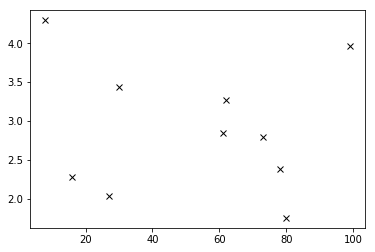

In [39]:
## create subset size for the trained data
sub = ma.ceil(perc*N)
## create fake data for model
noiseSize = 0.05

## define X values (integers from 0 to N)
X = np.arange(0,N+1,1)
## take sample for training
x_train = np.random.randint(0,N,sub)
x_train = x_train.reshape(-1,1)
x_train = x_train.astype(float)
y_train = np.sin(12*x_train) + 0.66*np.cos(25*x_train)  + np.random.randn(sub,1)*noiseSize + 3

## plot distribution of selected sensors
plt.plot(x_train, y_train, 'kx')

In [40]:
## build model
kernel = gpflow.kernels.RBF(1, active_dims=[0], lengthscales=1.0)
## build model
m = gpflow.models.GPR(x_train, y_train, kern=kernel)
m.likelihood.variance = 0.01

## view 
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [41]:
gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 18.673653
  Number of iterations: 19
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 18.673653
  Number of iterations: 19
  Number of functions evaluations: 22


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                value  
GPR/kern/lengthscales           True   12.249929783108312  
GPR/kern/variance               True   10.752711275527057  
GPR/likelihood/variance         True  0.12279649439486567  


In [42]:
## example: thought exercise
## 5 sensor locations: S = [4,5,6,7,8]
## total number of sensors to find: k = 2
## for each iteration (1:k):
    ## for each possible sensor location (y) not in A (S):
        ## calculate: corr(y)^2 - corr(yA)*np.linalg.inv(corr(AA))*corr(Ay) / corr(y)^2 - corr(ynA)*np.linalg.inv(corr(nAA))*corr(nAy)
    ## select max(store_val)
    ## append y to A

    
## selected sensors (indices)
A = np.array([],dtype=int)
## number of sensors to find
k = k
## define x_new as the new points not used for training
x_new = np.setdiff1d(X, x_train)
x_new = x_new.reshape(-1,1)
## define S as the incides of x_new
S = np.arange(0,x_new.shape[0]).reshape(x_new.shape[0],1)    

In [43]:
## x is np.array or single value
def generate_cov_mat(x):
    if not isinstance(x, np.ndarray):
        x = np.array(x).reshape(-1,1)
    ## select the 2nd object and bring up one dimension
    cov_mat = m.predict_f_full_cov(x)[1][0,:,:]
    return(cov_mat)

In [80]:
def pick_best_sensors_krause(S, X, k, A, verbose=False):

    ## take out locations already in A before checks
    S = S[np.isin(S, A, invert=True)]
    
    ## checks
    if k > S.shape[0]:
        print("error! k must be smaller than S")
        return
    if k/S.shape[0] > 0.25:
        print("Recommendation: k should be a significantly small fraction of S")
    
    ## print statements
    print("finding " + str(k) + " sensor locations of " + str(S.shape[0]) + " possible locations")
    
    ## next version: 
    ## add S + U
    ## add for 2-d, 3-d, etc
    
    ## create definition to generate model
    
    ## later version:
    ## use one full matrix and subset from
    
    ## additional checks:
    ## length of A + k should be less than S
    
    
    ## for each sensor to be added:
    for j in range(k):
        ## find the indices of coordinates not already in A to iterate through
        Y = S[np.isin(S, A, invert=True)]
        ## store the calculated value for each potential coordinate in order to take the max
        delta = np.array([])
        ## print iteration
        print("Starting iteration: " + str(j))
    
        for y in Y:
            ## define how many sensor sites already exist
            len_A = A.shape[0]
            ## combine indices of y and A
            yA = np.append(np.array([y]), A, axis=0)
            ## collect values of y and A using the indices
            yA_val = X[yA,:].reshape(yA.shape[0],X.shape[1])
            
            ## define the rest of possible sites taking out y and A
            nyA = S[np.isin(S, yA, invert=True)]
            len_nA = nyA.shape[0]
            ## define the indices of locations not in yA
            nyA = np.append(np.array([y]), nyA, axis=0)
            ## collect values of y and nA using the indices
            nyA_val = X[nyA,:].reshape(nyA.shape[0],X.shape[1])

            ## generate the covariance matrix:
            ##    y  A1  A2  ...
            ## y
            ## A1
            ## A2
            ## ...
            cov_mat_A = generate_cov_mat(yA_val)
            ## select y's covariance
            y_cov = cov_mat_A[:1,[0]]
            ## grab covariance values
            if len_A > 0:
                AA_cov = np.linalg.inv(cov_mat_A[1:len_A+1, 1:len_A+1])
                yA_cov = cov_mat_A[[0],1:len_A+1]
                Ay_cov = yA_cov.T
                calc_1 = y_cov**2 - np.dot(np.dot(yA_cov, AA_cov), Ay_cov)
            ## if A is empty: ignore the 2nd part of the calculation
            else:
                calc_1 = y_cov**2
            
            cov_mat_nA = generate_cov_mat(nyA_val)
            nAA_cov = np.linalg.inv(cov_mat_nA[1:len_nA+1, 1:len_nA+1])
            nyA_cov = cov_mat_nA[[0],1:len_nA+1]
            nAy_cov = nyA_cov.T
            calc_2 = y_cov**2 - np.dot(np.dot(nyA_cov, nAA_cov), nAy_cov)
            
            value = calc_1 / calc_2
            delta = np.append(delta, value)
            
        ## find the index with the largest delta
        y_star = np.array(Y[np.argmax(delta)])
        ## append to A as a new sensor site
        A = np.append(A, y_star)
        
        if verbose == True:
            #print(Y)
            #print(delta)
            print("Max value: " + str(np.amax(delta)))
            print("Picking sensor site: " + str(y_star))
    
    A_sites = X[A,:]
    return(A_sites)

In [81]:
best_sensors = pick_best_sensors_krause(S=S, X=x_new, k=k, A=A, verbose=False)
print(best_sensors)

finding 5 sensor locations of 45 possible locations
Starting iteration: 0


LinAlgError: Singular matrix

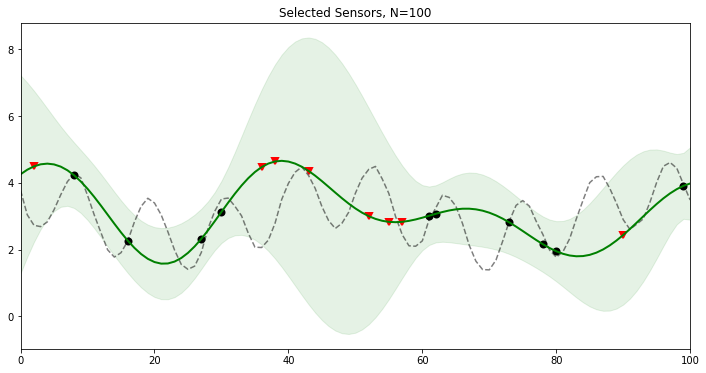

In [50]:
## WORKS ONLY FOR 1-D DATA
def plot(m, N):
    ## true underlying function: dashed line
    ## mean: green line
    ## shade: sd
    ## training points: black dots
    ## selected sensor points: red triangles
    xx = np.linspace(0, N, N+1)[:,None]
    ## actual function
    yy = np.sin(12*xx) + 0.66*np.cos(25*xx)  + np.random.randn(N+1,1)*noiseSize + 3
    ## predict values
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    
    mean_train, var_train = m.predict_y(x_train)
    plt.plot(x_train, mean_train, 'ko', mew=2)
    
    mean_sensors, var_sensors = m.predict_y(best_sensors)
    plt.plot(best_sensors, mean_sensors, 'rv', mew=2)
    
    plt.plot(xx, yy, 'k--', alpha=0.5)
    plt.plot(xx, mean, 'g', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='green', alpha=0.1)
    plt.xlim(0, N)
    plt.title('Selected Sensors, N=' + str(N))
    plt.savefig('../figures/selected_sensors_' + str(N))
plot(m, N)

In [51]:
## aggregated over time
dta = pd.read_csv("../data/kcl_london_model_data_winter_agg_time.csv", sep=',')
params = ['latitude', 'longitude']
X = dta[params].values
## rescale lat/long and year data
X = feature_scaler.fit_transform(X)
y = dta.loc[:,'nox'].values
y = y.reshape(-1,1)

In [52]:
print(X.shape)

(1981, 2)


In [53]:
## set max number
N = 50
## set number of sensor locations to find
k = 5
## set percent of N to train on
perc = .10

In [54]:
## subset to the trained data
sub = ma.ceil(perc*N)

In [60]:
## take sample for training
x_samps = np.random.randint(X.shape[0], size=sub)
x_train = X[x_samps,:]
y_train = y[x_samps,:]
## standardize y-values
y_train = feature_scaler.fit_transform(y_train)

In [61]:
## build model
kernel = gpflow.kernels.RBF(2, active_dims=[0,1], lengthscales=1.0)

## build model
m = gpflow.models.GPR(x_train, y_train, kern=kernel)
m.likelihood.variance = 0.01

## view 
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [62]:
## Run Model
## Marginal Liklihood Maximization
## picks the most simple model that picks the data the best
gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.094693
  Number of iterations: 22
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.094693
  Number of iterations: 22
  Number of functions evaluations: 23


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                 value  
GPR/kern/lengthscales           True   0.08189048480773539  
GPR/kern/variance               True    0.9895893435839797  
GPR/likelihood/variance         True  0.010407226259406818  


In [77]:
## define x-values not used for training
## iterate all of X
X_iter = np.arange(0,X.shape[0])
## take out the iters already used for training
x_new = np.setdiff1d(X_iter, x_samps)
## randomly select new iterations from the list
x_new_samps = np.random.choice(x_new, N-sub, replace=False)
print(x_samps)
print(x_new_samps)
x_new = X[x_new_samps,:]
print(x_new.shape)

[1281 1734  474 1102 1169]
[1258 1377 1565 1951 1957  407  588  459 1457 1602  984 1536 1732 1435
 1555  109  928  461 1532  176 1792 1634 1784 1434 1755 1106   29  227
 1101 1091 1310 1268 1344  479   59 1665  846  626   69 1884  504  323
  584 1840  748]
(45, 2)


In [79]:
## selected sensors (indices)
A = np.array([],dtype=int)
## number of sensors to find
k = k
## define S as the incides of x_new
S = np.arange(0,x_new.shape[0]).reshape(x_new.shape[0],1) 

In [74]:
## x is np.array or single value
def generate_cov_mat(x):
    if not isinstance(x, np.ndarray):
        x = np.array(x).reshape(-1,1)
    cov_mat = m.predict_f_full_cov(x)[1][0,:,:]
    return(cov_mat)

In [75]:
def pick_best_sensors_krause(S, X, k, A, verbose=False):

    ## take out locations already in A before checks
    #S = S[np.isin(S, A, invert=True)]
    
    ## checks
    if k > S.shape[0]:
        print("error! k must be smaller than S")
        return
    if k/S.shape[0] > 0.25:
        print("Recommendation: k should be a significantly small fraction of S")
    
    ## print statements
    print("finding " + str(k) + " sensor locations of " + str(S.shape[0]) + " possible locations")
    
    ## next version: 
    ## add S + U
    ## add for 2-d, 3-d, etc
    
    ## create definition to generate model
    
    ## later version:
    ## use one full matrix and subset from
    
    ## additional checks:
    ## length of A + k should be less than S
    
    
    ## for each sensor to be added:
    for j in range(k):
        ## find the indices of coordinates not already in A to iterate through
        Y = S[np.isin(S, A, invert=True)]
        ## store the calculated value for each potential coordinate in order to take the max
        delta = np.array([])
        ## print iteration
        print("Starting iteration: " + str(j))
    
        for y in Y:
            ## define how many sensor sites already exist
            len_A = A.shape[0]
            ## combine indices of y and A
            yA = np.append(np.array([y]), A, axis=0)
            ## collect values of y and A using the indices
            yA_val = X[yA,:].reshape(yA.shape[0],X.shape[1])
            
            ## define the rest of possible sites taking out y and A
            nyA = S[np.isin(S, yA, invert=True)]
            len_nA = nyA.shape[0]
            ## define the indices of locations not in yA
            nyA = np.append(np.array([y]), nyA, axis=0)
            ## collect values of y and nA using the indices
            nyA_val = X[nyA,:].reshape(nyA.shape[0],X.shape[1])

            ## generate the covariance matrix:
            ##    y  A1  A2  ...
            ## y
            ## A1
            ## A2
            ## ...
            cov_mat_A = generate_cov_mat(yA_val)
            ## select y's covariance
            y_cov = cov_mat_A[:1,[0]]
            ## grab covariance values
            if len_A > 0:
                AA_cov = np.linalg.inv(cov_mat_A[1:len_A+1, 1:len_A+1])
                yA_cov = cov_mat_A[[0],1:len_A+1]
                Ay_cov = yA_cov.T
                calc_1 = y_cov**2 - np.dot(np.dot(yA_cov, AA_cov), Ay_cov)
            ## if A is empty: ignore the 2nd part of the calculation
            else:
                calc_1 = y_cov**2
            
            cov_mat_nA = generate_cov_mat(nyA_val)
            nAA_cov = np.linalg.inv(cov_mat_nA[1:len_nA+1, 1:len_nA+1])
            nyA_cov = cov_mat_nA[[0],1:len_nA+1]
            nAy_cov = nyA_cov.T
            calc_2 = y_cov**2 - np.dot(np.dot(nyA_cov, nAA_cov), nAy_cov)
            
            value = calc_1 / calc_2
            delta = np.append(delta, value)
            
        ## find the index with the largest delta
        y_star = np.array(Y[np.argmax(delta)])
        ## append to A as a new sensor site
        A = np.append(A, y_star)
        
        if verbose == True:
            #print(Y)
            #print(delta)
            print("Max value: " + str(np.amax(delta)))
            print("Picking sensor site: " + str(y_star))
    
    A_sites = X[A,:]
    return(A_sites)

In [76]:
best_sensors = pick_best_sensors_krause(S=S, X=x_new, k=k, A=A, verbose=False)
print(best_sensors)

finding 5 sensor locations of 45 possible locations
Starting iteration: 0


LinAlgError: Singular matrix